In [2]:
import requests
import time
import os
import asyncio
import aiohttp
import nest_asyncio
import base64
import matplotlib.pyplot as plt
import threading

lock = threading.Lock()
# Apply nest_asyncio to allow nested event loops in Jupyter Notebook
nest_asyncio.apply()
%matplotlib inline




In [22]:
# Define constants
MAX_CHUNK_SIZE = 512 * 1024 - 200
anton_base_url = "http://localhost:8021"
bob_base_url = "http://localhost:8031"
data_folder = "data"

# Helper function to handle responses
async def handle_response(response):
    response.raise_for_status()
    return await response.json()

async def read_and_encode_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            file_content = file.read()
        encoded_content = base64.b64encode(file_content).decode('utf-8')
        return encoded_content
    except Exception as e:
        print(f"Failed to read and encode file {file_path}: {e}")
        return None


def split_into_chunks(encoded_content, chunk_size):
    return [encoded_content[i:i + chunk_size] for i in range(0, len(encoded_content), chunk_size)]

async def send_didcomm_message_async(session, send_message_url, message, latency_list, timestamps, start_time):
    try:
        url = send_message_url
        payload = message
        request_time = time.time()
        async with session.post(url, json=payload, headers={"Content-Type": "application/json"}) as response:
            response_time = time.time()
            latency = response_time - request_time
            latency_list.append(latency)
            elapsed_time = response_time - start_time
            timestamps.append(elapsed_time)
            await handle_response(response)
            print("Message sent successfully")
    except aiohttp.ClientError as e:
        print(f"Failed to send message: {e}")

async def test_performance(send_message_url, data_folder, parallel_count, num_repeats, latency_list, throughput_list, timestamps):
    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    encoded_files = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            encoded_content = await read_and_encode_file(file_path)
            if encoded_content:
                encoded_files.append((file_name, encoded_content))

    if not encoded_files:
        print("No files to encode and send.")
        return

    didcomm_message_template = {
        "type": "https://didcomm.org/file-transfer/1.0/message",
        "attachments": []
    }

    start_time = time.time()

    async with aiohttp.ClientSession() as session:
        for _ in range(num_repeats):
            tasks = []
            for file_name, encoded_content in encoded_files:
                chunks = split_into_chunks(encoded_content, MAX_CHUNK_SIZE)
                for idx, chunk in enumerate(chunks):
                    for _ in range(parallel_count):
                        didcomm_message = didcomm_message_template.copy()
                        didcomm_message["attachments"] = [
                            {
                                "filename": f"{file_name}.part{idx + 1}",
                                "data": {
                                    "base64": chunk
                                }
                            }
                        ]
                        didcomm_message["content"] = f"Sending file {file_name} part {idx + 1}"
                        tasks.append(send_didcomm_message_async(session, send_message_url, didcomm_message, latency_list, timestamps, start_time))
            await asyncio.gather(*tasks)

        for latency, chunk in zip(latency_list, [len(chunk) for file_name, encoded_content in encoded_files for chunk in split_into_chunks(encoded_content, MAX_CHUNK_SIZE)]):
            if latency != 0:
                throughput_list.append(chunk / latency)
            else:
                throughput_list.append(0)




def plot_metrics(latency_list, throughput_list, timestamps, data_folder):
    # Ensure all lists are of the same length
    min_length = min(len(latency_list), len(throughput_list), len(timestamps))
    latency_list = latency_list[:min_length]
    throughput_list = throughput_list[:min_length]
    timestamps = timestamps[:min_length]

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Latency (s)', color='tab:blue')
    ax1.plot(timestamps, latency_list, color='tab:blue', label='Latency')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Throughput (bytes/s)', color='tab:orange')
    ax2.plot(timestamps, throughput_list, color='tab:orange', label='Throughput')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title(f'Performance Metrics for {data_folder}')
    fig.legend(loc='upper left')

    # Save the plot to the data/performance directory
    performance_folder = os.path.join('data', 'performance')
    os.makedirs(performance_folder, exist_ok=True)
    #plot_path = os.path.join(performance_folder, f'{data_folder}_performance_metrics.png')
    #plt.savefig(plot_path)

    plt.show()


async def delete_connection(session, delete_url):
    async with session.delete(delete_url, headers={"Content-Type": "application/json"}) as response:
        status_code = response.status
        print(f"Deleted connection: {delete_url}")
        return status_code

async def fetch_connections(session, url):
    async with session.get(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)

async def create_request(session, url):
    async with session.post(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)



Deleted connection: http://localhost:8021/connections/2885a3bc-d197-4122-b80b-c486a19af869
Deleted connection: http://localhost:8021/connections/149fae49-8413-4273-b8b1-ed1d1061cf84
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent

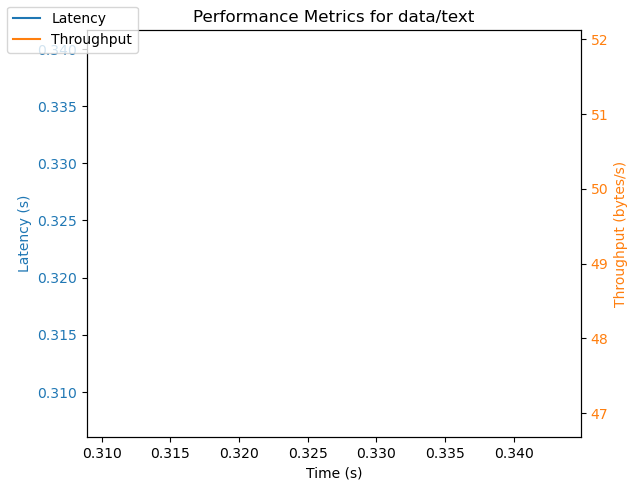

Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent

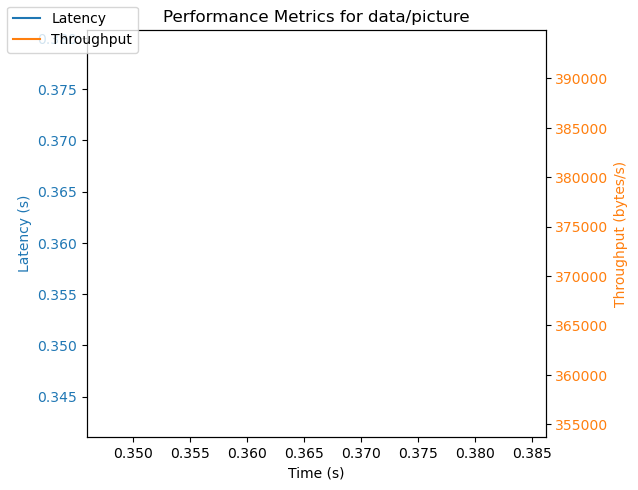

Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent successfully
Message sent

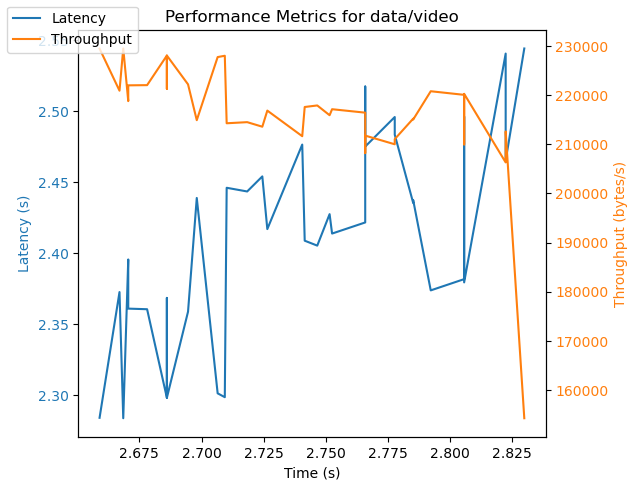

In [23]:
async def main():
    try:
        async with aiohttp.ClientSession() as session:
            # 1. Get Anton's connections and delete them
            anton_connections_url = f"{anton_base_url}/connections"
            anton_connections_response = await fetch_connections(session, anton_connections_url)
            anton_connections = anton_connections_response["results"]
            
            delete_tasks = []
            for connection in anton_connections:
                connection_id = connection["connection_id"]
                delete_url = f"{anton_base_url}/connections/{connection_id}"
                delete_tasks.append(delete_connection(session, delete_url))
            
            # Await all delete tasks
            await asyncio.gather(*delete_tasks)
        
            # 2. Get Bob's connections
            bob_connections_url = f"{bob_base_url}/connections"
            bob_connections_response = await fetch_connections(session, bob_connections_url)
        
            # 3. Bob sends a connection request to Anton
            bob_create_request_url = f"{bob_base_url}/didexchange/create-request?their_public_did=NyaE9SFSneSNRq6Ch8N9Pt&alias=Anton"
            bob_create_request_response = await create_request(session, bob_create_request_url)
            #bob_connection_id = bob_create_request_response["connection_id"]
        
            # Wait for the connection request to appear in Anton's connections
            await asyncio.sleep(2) 
        
            # 4. query again (if in different machines, ignore all step 1-3)
            anton_connections_url = f"{anton_base_url}/connections"
            anton_connections_response = await fetch_connections(session, anton_connections_url)
            anton_connections = anton_connections_response["results"]

            bob_connection_id = bob_connection_id = anton_connections[0]["connection_id"]

            # 5. Anton sends a message to Bob
            send_message_url = f"{anton_base_url}/connections/{bob_connection_id}/send-message"

            test_cases = [
                ('data/text', 50, 2),
                ('data/picture', 50, 2),
                ('data/video', 20, 2),
            ]

            for data_folder, parallel_count, num_repeats in test_cases:
                latency_list = []
                throughput_list = []
                timestamps = []
                await test_performance(send_message_url, data_folder, parallel_count, num_repeats, latency_list, throughput_list, timestamps)
                plot_metrics(latency_list, throughput_list, timestamps, data_folder)
    except KeyboardInterrupt:
        print("Process interrupted by user")

# Run the main function
try:
    asyncio.run(main())
except KeyboardInterrupt:
    print("Process interrupted by user")

